In [10]:
import Pkg
Pkg.add(["CombinatorialSpaces", "GeometryBasics", "Decapodes", "MultiScaleArrays", "MLStyle", 
        "OrdinaryDiffEq", "LinearAlgebra", "GLMakie", "Logging", "JLD2", "Printf"])
using Catlab
using Catlab.Graphics
using CombinatorialSpaces
using CombinatorialSpaces.ExteriorCalculus
using Decapodes
using MultiScaleArrays
using MLStyle
using OrdinaryDiffEq
using LinearAlgebra
using GLMakie
using Logging
using JLD2
using Printf

using GeometryBasics: Point2, Point3
Point2D = Point2{Float64}
Point3D = Point3{Float64}

We use the model equations as stated here and use the initial conditions for
$f, k, rᵤ, rᵥ$ as listed for experiment 4.

 https://groups.csail.mit.edu/mac/projects/amorphous/GrayScott/

In [10]:
GrayScott = @decapode begin
  (U, V)::Form0
  (UV2)::Form0
  (U̇, V̇)::Form0
  (f, k, rᵤ, rᵥ)::Constant
  UV2 == (U .* (V .* V))
  U̇ == rᵤ * Δ(U) - UV2 + f * (1 .- U)
  V̇ == rᵥ * Δ(V) + UV2 - (f + k) .* V
  ∂ₜ(U) == U̇
  ∂ₜ(V) == V̇
end

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [5c1252a2] + GeometryBasics v0.4.9
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Var,type,name
1,Form0,U
2,Form0,V
3,Form0,UV2
4,Form0,U̇
5,Form0,V̇
6,Constant,f
7,Constant,k
8,Constant,rᵤ
9,Constant,rᵥ
10,infer,sum_1


# Visualize. You must have graphviz installed.

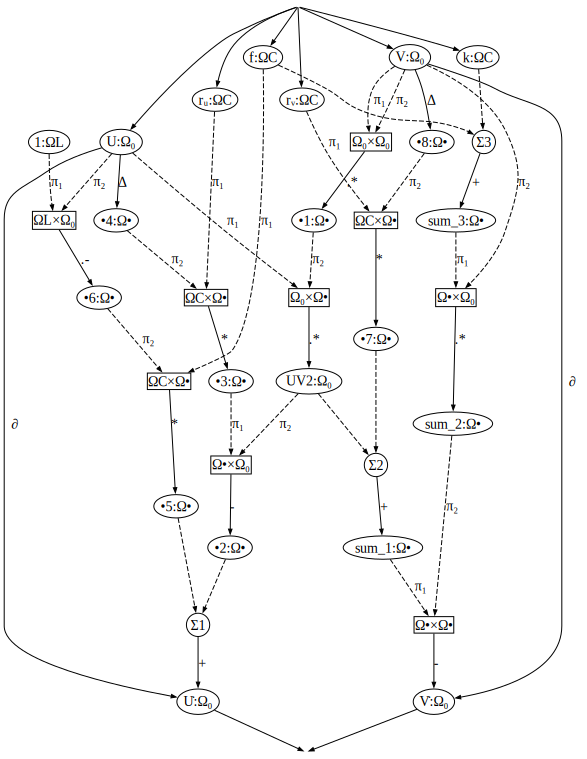

In [11]:
to_graphviz(GrayScott)

# We resolve types of intermediate variables using sets of rules.

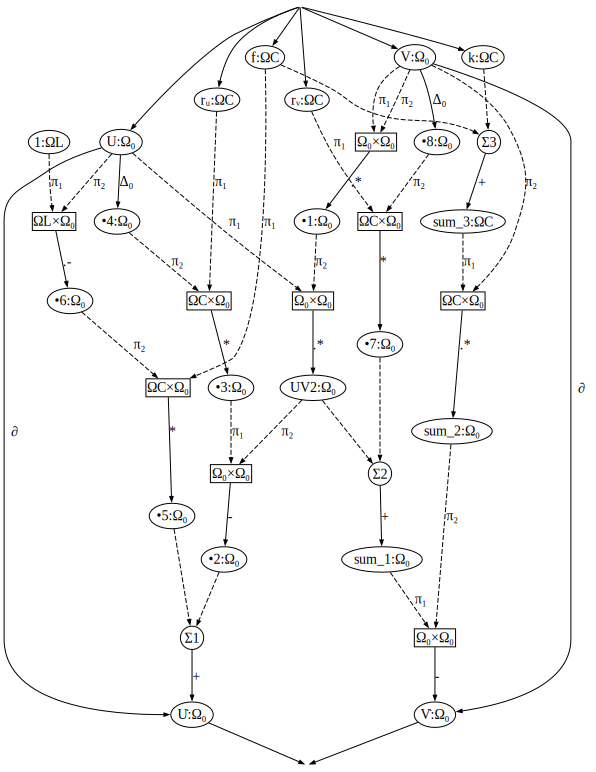

In [17]:
infer_types!(GrayScott)
to_graphviz(GrayScott)

# Resolve overloads. i.e. ~dispatch

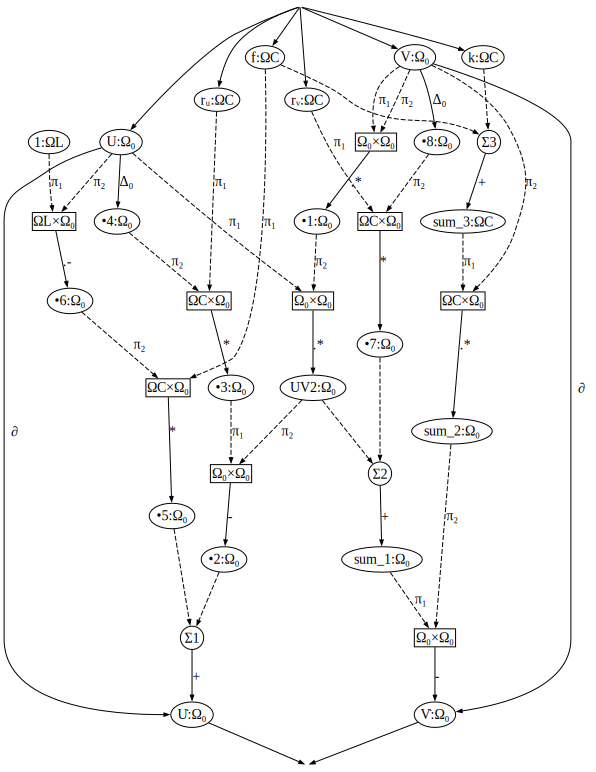

In [13]:
resolve_overloads!(GrayScott)
to_graphviz(GrayScott)

In [14]:
s = loadmesh(Rectangle_30x10())
scaling_mat = Diagonal([1/maximum(x->x[1], s[:point]),
                        1/maximum(x->x[2], s[:point]),
                        1.0])
s[:point] = map(x -> scaling_mat*x, s[:point])
s[:edge_orientation] = false
orient!(s)

# Visualize the mesh.

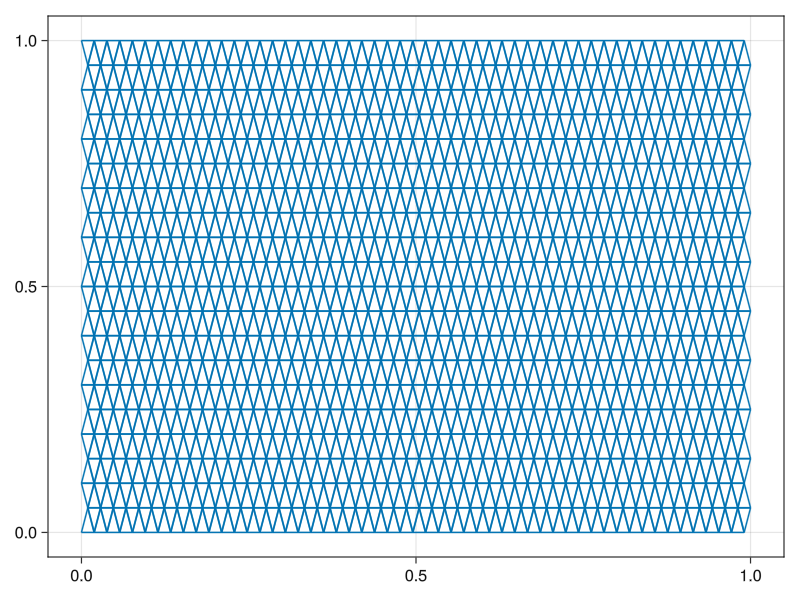

In [14]:
GLMakie.wireframe(s)

In [15]:
sd = EmbeddedDeltaDualComplex2D{Bool,Float64,Point2D}(s)
subdivide_duals!(sd, Circumcenter())

# Define how operations map to Julia functions.

In [21]:
function generate(sd, my_symbol; hodge=GeometricHodge()) end

generate (generic function with 1 method)

# Create initial data.

In [22]:
@assert all(map(sd[:point]) do (x,y)
  0.0 ≤ x ≤ 1.0 && 0.0 ≤ y ≤ 1.0
end)

U = map(sd[:point]) do (_,y)
  22 * (y *(1-y))^(3/2)
end

V = map(sd[:point]) do (x,_)
  27 * (x *(1-x))^(3/2)
end

constants_and_parameters = (
  f = 0.024,
  k = 0.055,
  rᵤ = 0.01,
  rᵥ = 0.005)

(f = 0.024, k = 0.055, rᵤ = 0.01, rᵥ = 0.005)

# Generate the simulation.

In [23]:
gensim(expand_operators(GrayScott))
sim = eval(gensim(expand_operators(GrayScott)))
fₘ = sim(sd, generate)

(::var"#f#36"{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}) (generic function with 1 method)

Create problem and run sim for $t ∈ [0,tₑ).$

Map symbols to data.

In [24]:
mu₀ = construct(PhysicsState, [VectorForm(U), VectorForm(V)], Float64[], [:U, :V])

PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), VectorForm{Float64}([0.0, 0.06895991182385794, 0.18939474056829575, 0.33765682652037976, 0.5041832911064666, 0.6829379944980206, 0.8695451935512495, 1.0605960588272993, 1.2533167703368961, 1.4453848674511058  …  1.5405434267018179, 1.349563292841857, 1.156901861022958, 0.9647007950127365, 0.7754908448886847, 0.5923337528437551, 0.4190656273186813, 0.26076594489793503, 0.12484697001674609, 0.02473693431667157])], Float64[], [1113, 2226], [:U, :V])

# Visualize the initial conditions.
If GLMakie throws errors, then update your graphics drivers, or use an alternative Makie backend like CairoMakie.

In [25]:
fig_ic = GLMakie.Figure()
p1 = GLMakie.mesh(fig_ic[1,2], s, color=findnode(u₀, :U), colormap=:jet)
p2 = GLMakie.mesh(fig_ic[1,3], s, color=findnode(u₀, :V), colormap=:jet)
display(fig_ic)

GLMakie.Screen(...)

In [26]:
tₑ = 11.5

@info("Precompiling Solver")
prob = ODEProblem(fₘ, u₀, (0, 1e-4), constants_and_parameters)
soln = solve(prob, Tsit5())
soln.retcode != :Unstable || error("Solver was not stable")
@info("Solving")
prob = ODEProblem(fₘ, u₀, (0, tₑ), constants_and_parameters)
soln = solve(prob, Tsit5())
@info("Done")

@save "gray_scott.jld2" soln

[ Info: Precompiling Solver
[ Info: Solving
[ Info: Done


# Visualize the final conditions.

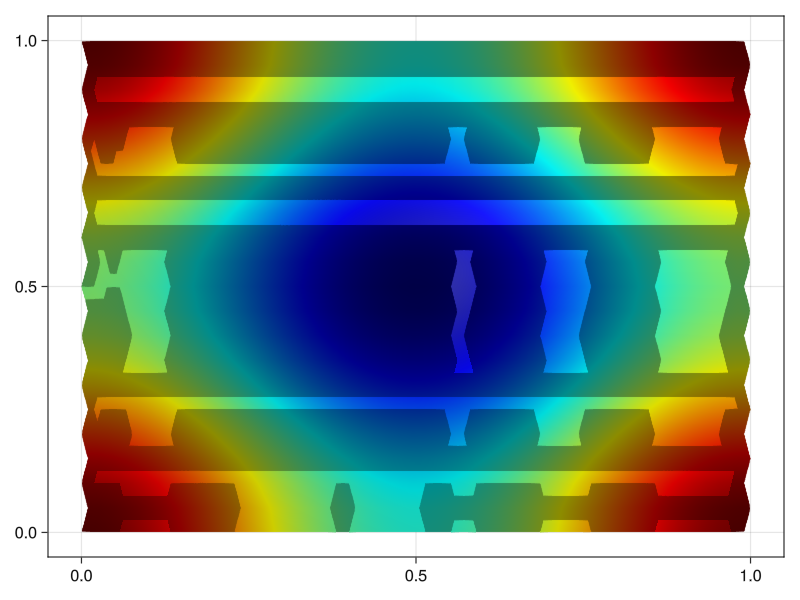

In [27]:
GLMakie.mesh(s, color=findnode(soln(tₑ), :U), colormap=:jet)

In [28]:
begin # BEGIN Gif creation
frames = 100
# Initial frame
fig = GLMakie.Figure(resolution = (1200, 800))
p1 = GLMakie.mesh(fig[1,2], s, color=findnode(soln(0), :U), colormap=:jet, colorrange=extrema(findnode(soln(0), :U)))
p2 = GLMakie.mesh(fig[1,4], s, color=findnode(soln(0), :V), colormap=:jet, colorrange=extrema(findnode(soln(0), :V)))
ax1 = Axis(fig[1,2], width = 400, height = 400)
ax2 = Axis(fig[1,4], width = 400, height = 400)
hidedecorations!(ax1)
hidedecorations!(ax2)
hidespines!(ax1)
hidespines!(ax2)
Colorbar(fig[1,1], colormap=:jet, colorrange=extrema(findnode(soln(0), :U)))
Colorbar(fig[1,5], colormap=:jet, colorrange=extrema(findnode(soln(0), :V)))
Label(fig[1,2,Top()], "U")
Label(fig[1,4,Top()], "V")
lab1 = Label(fig[1,3], "")

# Animation
record(fig, "gray_scott.gif", range(0.0, tₑ; length=frames); framerate = 15) do t
    p1.plot.color = findnode(soln(t), :U)
    p2.plot.color = findnode(soln(t), :V)
    lab1.text = @sprintf("%.2f",t)
end

end # END Gif creation

"gray_scott.gif"

# Run on the sphere.
You can use lower resolution meshes, such as Icosphere(3).

In [29]:
s = loadmesh(Icosphere(5))
orient!(s)

true

# Visualize the mesh.

In [30]:
GLMakie.wireframe(s)
sd = EmbeddedDeltaDualComplex2D{Bool,Float64,Point3D}(s)
subdivide_duals!(sd, Circumcenter())

# Define how operations map to Julia functions.

In [31]:
function generate(sd, my_symbol; hodge=GeometricHodge()) end

# Create initial data.
U = map(sd[:point]) do (_,y,_)
  abs(y)
end

V = map(sd[:point]) do (x,_,_)
  abs(x)
end

constants_and_parameters = (
  f = 0.024,
  k = 0.055,
  rᵤ = 0.01,
  rᵥ = 0.005)

(f = 0.024, k = 0.055, rᵤ = 0.01, rᵥ = 0.005)

# Generate the simulation.

In [32]:
fₘ = sim(sd, generate)

(::var"#f#36"{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}) (generic function with 1 method)

# Create problem and run sim for $t ∈ [0,tₑ).$
Map symbols to data.

In [33]:
u₀ = construct(PhysicsState, [VectorForm(U), VectorForm(V)], Float64[], [:U, :V])

PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([1.0, 0.44721999764442444, 0.44721999764442444, 0.4472160041332245, 0.44721999764442444, 0.44721999764442444, 0.44721999764442444, 0.44721999764442444, 0.44721999764442444, 0.44721999764442444  …  0.9346749782562256, 0.9048699736595154, 0.8689979910850525, 0.8275079727172852, 0.7811669707298279, 0.7309939861297607, 0.67815101146698, 0.6238319873809814, 0.5691580176353455, 0.5151029825210571]), VectorForm{Float64}([0.0, 0.7236070036888123, 0.2763879895210266, 0.8944259881973267, 0.2763879895210266, 0.7236070036888123, 0.2763879895210266, 0.7236070036888123, 0.7236070036888123, 0.2763879895210266  …  0.2462570071220398, 0.30324599146842957, 0.35944101214408875, 0.4137530028820038, 0.4651769995689392, 0.5128819942474365, 0.5562760233879089, 0.5950289964675903, 0.6290590167045593, 0.6584960222244263])], Float64[], [2562, 5124], [:U, :V])

# Visualize the initial conditions.
If GLMakie throws errors, then update your graphics drivers,
or use an alternative Makie backend like CairoMakie.

In [34]:
fig_ic = GLMakie.Figure()
p1 = GLMakie.mesh(fig_ic[1,2], s, color=findnode(u₀, :U), colormap=:jet)
p2 = GLMakie.mesh(fig_ic[1,3], s, color=findnode(u₀, :V), colormap=:jet)
display(fig_ic)

tₑ = 11.5

@info("Precompiling Solver")
prob = ODEProblem(fₘ, u₀, (0, 1e-4), constants_and_parameters)
soln = solve(prob, Tsit5())
soln.retcode != :Unstable || error("Solver was not stable")
@info("Solving")
prob = ODEProblem(fₘ, u₀, (0, tₑ), constants_and_parameters)
soln = solve(prob, Tsit5())
@info("Done")

@save "gray_scott_sphere.jld2" soln

[ Info: Precompiling Solver
[ Info: Solving
[ Info: Done


# Visualize the final conditions.

In [35]:
GLMakie.mesh(s, color=findnode(soln(tₑ), :U), colormap=:jet)

begin # BEGIN Gif creation
frames = 800
# Initial frame
fig = GLMakie.Figure(resolution = (1200, 1200))
p1 = GLMakie.mesh(fig[1,1], s, color=findnode(soln(0), :U), colormap=:jet, colorrange=extrema(findnode(soln(0), :U)))
p2 = GLMakie.mesh(fig[2,1], s, color=findnode(soln(0), :V), colormap=:jet, colorrange=extrema(findnode(soln(0), :V)))
Colorbar(fig[1,2], colormap=:jet, colorrange=extrema(findnode(soln(0), :U)))
Colorbar(fig[2,2], colormap=:jet, colorrange=extrema(findnode(soln(0), :V)))

# Animation

record(fig, "gray_scott_sphere.gif", range(0.0, tₑ; length=frames); framerate = 30) do t
    p1.plot.color = findnode(soln(t), :U)
    p2.plot.color = findnode(soln(t), :V)
end

end # END Gif creation

"gray_scott_sphere.gif"